 ### 1)Initialize EasyOCR Reader

In [40]:
import easyocr
import cv2
import matplotlib.pyplot as plt

reader = easyocr.Reader(['en'], gpu=False)


Using CPU. Note: This module is much faster with a GPU.


### 2. Load Binary Image & Extract Connected Components

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr

# Load binary image (white background, black text)
img = cv2.imread("document.png", cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
    binary, connectivity=8
)

components = []
for i in range(1, num_labels):  # skip background
    x, y, w, h, area = stats[i]
    comp_img = binary[y:y+h, x:x+w]
    components.append({
        "bbox": (x, y, w, h),
        "image": comp_img
    })


### 3. Shape Descriptor (Hu Moments + Size)

In [42]:
def shape_descriptor(img):
    moments = cv2.moments(img)
    hu = cv2.HuMoments(moments).flatten()
    hu = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)

    h, w = img.shape
    aspect_ratio = w / h

    return np.concatenate([hu, [w, h, aspect_ratio]])


### 4. Similarity Measure

In [43]:
def distance(d1, d2):
    return np.linalg.norm(d1 - d2)


### 5. Group Components Using a Threshold

In [44]:
def group_components(components, threshold):
    descriptors = [shape_descriptor(c["image"]) for c in components]
    groups = []

    for i, desc in enumerate(descriptors):
        matched = False
        for group in groups:
            if distance(desc, group["prototype_desc"]) < threshold:
                group["members"].append(i)
                matched = True
                break
        if not matched:
            groups.append({
                "prototype_desc": desc,
                "members": [i]
            })
    return groups


### 6. Reconstruct Image Using Prototype Substitution

In [45]:
def reconstruct_image(components, groups, shape):
    recon = np.zeros(shape, dtype=np.uint8)

    for group in groups:
        proto_idx = group["members"][0]
        proto_img = components[proto_idx]["image"]

        for idx in group["members"]:
            x, y, w, h = components[idx]["bbox"]
            resized = cv2.resize(proto_img, (w, h))
            recon[y:y+h, x:x+w] = resized

    return recon


### 7. Run EasyOCR for Character Detection

In [46]:
reader = easyocr.Reader(['en'], gpu=False)

def easyocr_characters(img):
    rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    results = reader.readtext(rgb, detail=1, paragraph=False)
    chars = []
    for (_, text, conf) in results:
        if conf > 0.5:
            chars.extend(list(text))
    return chars


Using CPU. Note: This module is much faster with a GPU.


### 8. Experiment: Vary the Similarity Threshold

/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Threshold = 0.1
Groups formed = 76
Detected characters: ['T', 'h', 'i', 's', ' ', 'i', 's', ' ', 'a', ' ', 'l', 'o', 't', ' ', 'o', 'f', ' ', '1', '2', ' ', 'p', 'o', 'i', 'n', 't', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 't', 'e', 's', 't', ' ', 't', 'h', 'e', 'o', 'c', 'r', ' ', 'c', 'o', 'p', 'e', ' ', 'a', 'n', 'd', ' ', 's', 'e', 'e', ' ', 'i', 'f', ' ', 'i', 't', ' ', 'w', 'o', 'r', 'k', 's', ' ', 'o', 'n', 'a', 'l', 'l', ' ', 't', 'y', 'p', 'e', 's', 'o', 'f', ' ', 'f', 'i', 'l', 'e', ' ', 'f', 'o', 'r', 'm', 'a', 't', ':', 'T', 'h', 'e', ' ', 'd', 'u', 'i', 'c', 'k', ' ', 'd', 'r', 'o', 'w', 'n', 'j', 'u', 'm', 'p', 'e', 'p', ' ', 'o', 'v', 'e', 'r', ' ', 't', 'h', 'e', 'l', 'a', 'z', 'y', ' ', 'f', 'o', 'x', '.', ' ', 'T', 'h', 'e', ' ', 'd', 'u', 'i', 'c', 'k', ' ', 'd', 'r', 'o', 'w', 'n', 'j', 'u', 'm', 'p', 'e', 'd', 'o', 'v', 'e', 'r', ' ', 't', 'h', 'e', ' ', 'l', 'a', 'z', 'y', ' ', 'f', 'o', 'x', '.', ' ', 'T', 'h', 'e', ' ', 'd', 'u', 'i', 'c', 'k', ' ', 'd', 'r

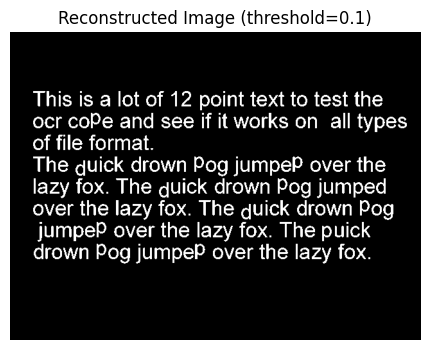


Threshold = 1
Groups formed = 57
Detected characters: ['T', 'h', 'i', 's', ' ', 'i', 's', ' ', 'a', ' ', 'l', 'o', 't', ' ', 'o', 'f', ' ', '1', '2', ' ', 'p', 'o', 'i', 'n', 't', ' ', 't', 'o', 'x', 't', ' ', 't', 'o', ' ', 't', 'e', 's', 't', ' ', 't', 'h', 'o', 'o', 'a', 'r', ' ', 'c', 'o', 'p', 'o', ' ', 'a', 'n', 'd', ' ', 's', 'O', 'o', ' ', 'i', 'f', ' ', 'i', 't', ' ', 'w', 'o', 'r', 'k', 's', ' ', 'o', 'n', 'a', 'l', 'l', ' ', 't', 'y', 'p', 'e', 's', 'o', 'f', ' ', 'f', 'i', 'l', 'e', ' ', 'f', 'o', 'r', 'm', 'o', 't', 'T', 'h', 'e', ' ', 'd', 'u', 'i', 'a', 'k', ' ', 'd', 'r', 'o', 'w', 'n', 'j', 'n', 'm', 'p', 'o', 'p', ' ', 'o', 'v', 'e', 'r', ' ', 't', 'h', 'e', 'f', 'o', 'x', '.', ' ', 'T', 'h', 'o', ' ', 'd', 'n', 'i', 'c', 'h', ' ', 'd', 'r', 'o', 'w', 'n', 'j', 'n', 'm', 'p', 'o', 'd', 'o', 'v', 'o', 'r', ' ', 't', 'h', 'o', ' ', 'l', 'a', 'c', 'y', ' ', 'f', 'o', 'x', '.', ' ', 'T', 'h', 'e', ' ', 'd', 'u', 'i', 'a', 'k', ' ', 'd', 'r', 'o', 'w', 'n', 'j', 'n', 'w',

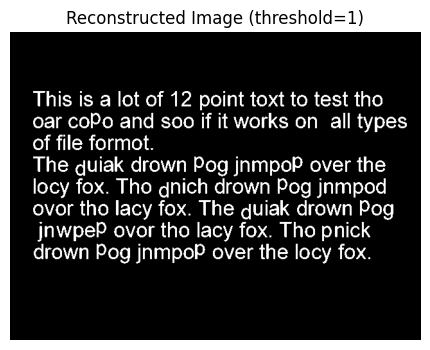


Threshold = 3
Groups formed = 34
Detected characters: ['T', 'h', 'i', 's', ' ', 'i', 's', ' ', 'a', ' ', 'l', 'o', 't', ' ', 's', 'f', ' ', '1', '2', ' ', 'p', 'o', 'i', 'n', 't', ' ', 't', 'o', 'x', 't', ' ', 't', 'o', ' ', 't', 'x', 's', 't', ' ', 't', 'h', 'o', 's', 'a', 'r', ' ', 'a', 'a', 'p', 'o', ' ', 'a', 'n', 'd', ' ', 'n', 'o', 'o', ' ', 'i', 't', ' ', 'i', 't', ' ', 'w', 's', 'r', '2', 's', ' ', 'a', 'n', 'a', 'l', 'l', ' ', 't', 'h', 'h', 'x', 's', 's', 'f', ' ', 't', 'i', 'l', 'x', ' ', 't', 'o', 'r', 'm', 'a', 't', 'T', 'h', 'x', ' ', 'd', 'o', 'i', 'a', '2', ' ', 'd', 'r', 'o', 'w', 'n', 't', 'n', 'm', 'p', 'o', 'h', ' ', 'o', 'n', 'x', 'r', ' ', 't', 'h', 'x', 't', 's', 'x', '.', ' ', 'T', 'h', 'o', ' ', 'd', 'n', 'i', 'o', 'h', ' ', 'd', 'r', 's', 'w', 'n', 'j', 'n', 'm', 'p', 'o', 'd', 's', 'n', 'o', 'r', ' ', 't', 'h', 'o', 't', 'o', 'x', '.', ' ', 'T', 'h', 'x', ' ', 'd', 'o', 'i', 'a', '2', ' ', 'd', 'r', 'o', 'w', 'n', 'j', 'n', 'W', 'h', 'x', 'p', ' ', 'o', 'n',

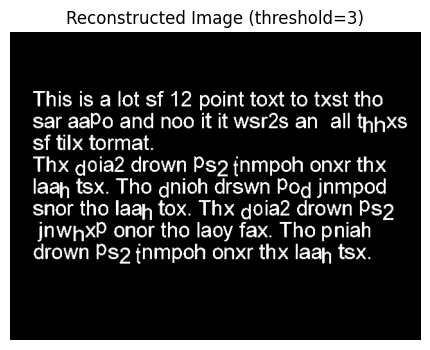


Threshold = 6
Groups formed = 29
Detected characters: ['T', 'h', 'i', 's', ' ', 'i', 's', ' ', 'a', ' ', 'l', 'o', 't', ' ', 's', 't', ' ', '1', '2', ' ', 'T', 'o', 'i', 'n', 't', ' ', 't', 'o', 'x', 't', ' ', 't', 'o', ' ', 't', 'x', 's', 't', ' ', 't', 'h', 'o', 's', 'a', 't', ' ', 'a', 'a', 'T', 'o', ' ', 'a', 'n', 'd', ' ', 'n', 'o', 'o', ' ', 'i', 't', ' ', 'i', 't', ' ', 'w', 's', 'r', '2', 's', ' ', 'a', 'n', 'a', 'l', 'l', ' ', 't', 'h', 'h', 'x', 's', 's', 't', ' ', 't', 'i', 't', 'x', ' ', 't', 'o', 't', 'm', 'a', 't', 'T', 'h', 'x', ' ', 'd', 'o', 'i', 'a', '2', ' ', 'd', 'r', 'o', 'w', 'n', 't', 'n', 'm', 't', 'o', 'h', ' ', 'o', 'n', 'x', 't', ' ', 't', 'h', 'x', 't', 's', 'x', '.', ' ', 'd', 'h', 'o', ' ', 'd', 'n', 'i', 'o', 'h', ' ', 'd', 't', 's', 'w', 'n', 'j', 'n', 'm', 't', 'o', 'd', 's', 'n', 'o', 't', ' ', 't', 'h', 'o', 't', 'o', 'x', '.', ' ', 'T', 'h', 'x', ' ', 'd', 'o', 'i', 'a', '2', ' ', 'd', 'r', 'o', 'w', 'n', 'j', 'n', 'W', 'h', 'x', 'T', ' ', 'o', 'n',

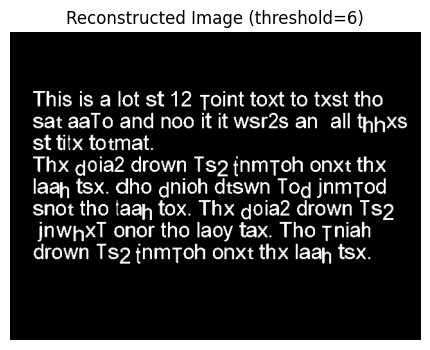


Threshold = 8
Groups formed = 20
Detected characters: ['s', 'a', 't', ' ', 'a', 'a', 'T', '2', ' ', 'a', 'h', '1', 'h', '2', '2', ' ', 'i', 't', ' ', 'i', 't', ' ', 'W', 'S', '2', '2', 's', ' ', 'a', 'h', 'a', 'l', 'l', ' ', 't', 'h', 'h', 'T', 's', 's', 't', ' ', 't', 'i', 't', 't', ' ', 't', 'z', 't', 'm', 'a', 't', 'T', 'h', 'T', ' ', '1', '2', 'i', 'a', '2', ' ', 'I', 'z', '2', 'W', 'h', 't', 'h', 'm', 't', 'z', 'h', ' ', 'O', 'h', 'T', 't', ' ', 't', 'h', 't', 'j', 'h', 'm', 'T', '2', '1', 'S', 'h', '2', 't', ' ', 't', 'S', '2', 'j', 'h', 'W', 'h', 'T', 'T', ' ', '2', 'h', '2', '2', ' ', 't', 'h', 'z', ' ', 'l', 'a', 'z', 'a', ' ', 't', 'a', 't', 'T', 'S', '2', ' ', 'T', 'h', 'i', 'a', 'h', '1', '2', '2', 'W', 'h', 't', 'h', 'm', 't', 'z', 'h', ' ', 'O', 'h', 'T', 't', ' ', 't', 'h', 'T', ' ', 'l', 'a', 'a', 'h', ' ', 't', 's', 't', '.', 'T', 's', '2', 'l', 'a', 'a', 'h', 'T', 'o', '1', 'I', 'a', 'a', 'h', 'T', 's', '2', 'T', 's', '2']


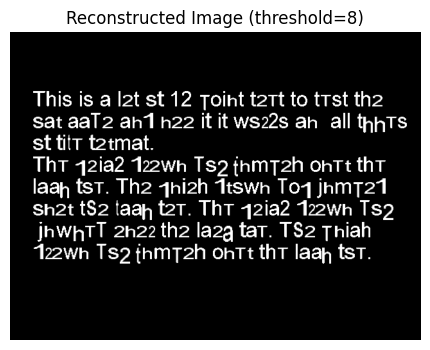


Threshold = 9
Groups formed = 18
Detected characters: ['T', 'h', 'i', 's', ' ', 'i', 's', ' ', 'a', ' ', 'I', 'z', 't', ' ', 's', 'T', ' ', '1', '2', ' ', 'T', 'o', 'i', 'h', 't', ' ', 't', 'z', 't', 't', ' ', 't', 'o', ' ', 't', 'r', 's', 't', ' ', 't', 'h', 'z', 's', 'a', 't', ' ', 'a', 'a', 'T', '2', ' ', 'a', 'h', '1', 'h', '2', '2', ' ', 'i', 't', ' ', 'i', 't', ' ', 'W', 'S', '2', '2', 's', ' ', 'a', 'h', 'a', 'l', 'l', ' ', 't', 'h', 'h', 'T', 's', 's', 'T', ' ', 't', 'i', 't', 't', ' ', 't', 'z', 't', 'a', 'a', 't', 'T', 'h', 'T', ' ', '1', '2', 'i', 'a', '2', ' ', 'I', 'z', '2', 'W', 'h', 't', 'h', 'm', 't', 'z', 'h', ' ', 'O', 'h', 'T', 't', ' ', 't', 'h', 't', 'j', 'h', 'm', 'T', '2', '1', 'S', 'h', '2', 't', ' ', 't', 'S', '2', 'i', 'h', 'W', 'h', 'T', 'T', ' ', '2', 'h', '2', '2', ' ', 't', 'h', 'z', ' ', 'l', 'a', 'z', 'a', ' ', 'T', 'a', 't', 'T', 'S', '2', ' ', 'T', 'h', 'i', 'a', 'h', '1', '2', '2', 'W', 'h', 't', 'h', 'm', 't', 'z', 'h', ' ', 'O', 'h', 'T', 't', ' ',

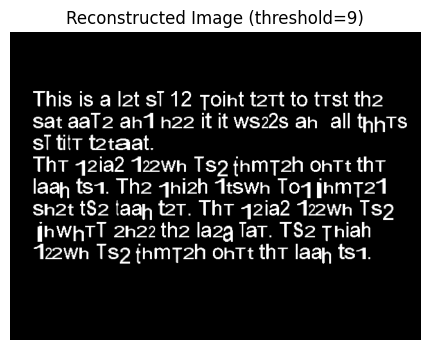


Threshold = 10
Groups formed = 17
Detected characters: ['T', 'h', 'i', 's', ' ', 'i', 's', ' ', 'a', ' ', 'I', 'z', 't', ' ', 's', 'T', ' ', '1', '2', ' ', 'T', 'o', 'i', 'h', 't', ' ', 't', 'z', 't', 't', ' ', 't', 'o', ' ', 't', 'r', 's', 't', ' ', 't', 'h', 'z', 's', 'a', 't', ' ', 'a', 'a', 'T', '2', ' ', 'a', 'h', '1', 'h', '2', '2', ' ', 'i', 'T', ' ', 'i', 't', ' ', 'W', 'S', '2', '2', 's', ' ', 'a', 'h', 'a', 'l', 'l', ' ', 't', 'h', 'h', 'T', 's', 'T', 'h', 'T', ' ', '1', '2', 'i', 'a', '2', ' ', '1', '2', '2', 'W', 'h', 't', 'h', 'm', 't', 'z', 'h', ' ', 'O', 'h', 'T', 't', ' ', 't', 'h', 't', 'S', 'h', '2', 't', ' ', 't', 'S', '2', 'i', 'h', 'W', 'h', 'T', 'T', ' ', '2', 'h', '2', '2', ' ', 't', 'h', 'z', ' ', 'l', 'a', 'z', 'a', ' ', 'T', 'a', 't', 'T', 'S', '2', ' ', 'T', 'h', 'i', 'a', 'h', '1', '2', '2', 'W', 'h', 't', 'h', 'm', 't', 'z', 'h', ' ', 'O', 'h', 'T', 't', ' ', 't', 'h', 'T', ' ', 'l', 'a', 'a', 'h', ' ', 'T', 's', '1', '.', 'T', 's', '2', 'l', 'a', 'a', 'h'

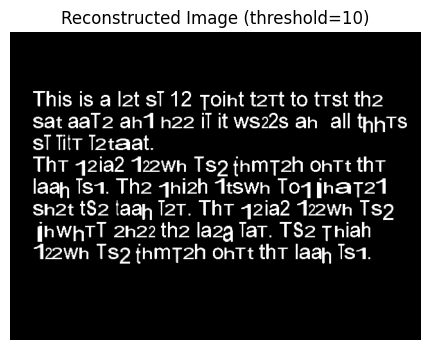

In [47]:
thresholds = [0.1,1,3,6,8,9,10]

for t in thresholds:
    groups = group_components(components, threshold=t)
    recon = reconstruct_image(components, groups, binary.shape)

    chars = easyocr_characters(recon)

    print(f"\nThreshold = {t}")
    print(f"Groups formed = {len(groups)}")
    print("Detected characters:", chars)

    plt.figure(figsize=(6,4))
    plt.title(f"Reconstructed Image (threshold={t})")
    plt.imshow(recon, cmap="gray")
    plt.axis("off")
    plt.show()


### 9. What You Will Observe (Key Result)

# Task 2

Human-Visible vs Machine-Relevant Differences

Problem statement

Take a grayscale image with text or fine patterns. Generate multiple compressed versions using JPEG at different quality levels.

Tasks

Compute PSNR and SSIM between the original and compressed images.

Apply a simple edge detector or OCR preprocessing step on each version.

Compare how perceptual metrics (PSNR/SSIM) and algorithmic outputs change with compression.

### 2. Load Grayscale Image

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Load grayscale image
orig = cv2.imread("document.png", cv2.IMREAD_GRAYSCALE)


### 3. Generate JPEG Compressed Versions

In [49]:
qualities = [100, 70, 40, 20]
compressed_images = {}

for q in qualities:
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), q]
    _, enc = cv2.imencode(".jpg", orig, encode_param)
    dec = cv2.imdecode(enc, cv2.IMREAD_GRAYSCALE)
    compressed_images[q] = dec


### 4. Compute PSNR and SSIM

In [50]:
print("Quality | PSNR (dB) | SSIM")
print("-----------------------------")

metrics = {}

for q, img in compressed_images.items():
    p = psnr(orig, img)
    s = ssim(orig, img)
    metrics[q] = (p, s)
    print(f"{q:>7} | {p:8.2f} | {s:.4f}")


Quality | PSNR (dB) | SSIM
-----------------------------
    100 |    68.55 | 1.0000
     70 |    35.57 | 0.9734
     40 |    29.51 | 0.9502
     20 |    25.19 | 0.9360


### 5. Apply Edge Detection (Machine-Relevant Step)

In [51]:
def edge_map(img):
    return cv2.Canny(img, 100, 200)

edges = {q: edge_map(img) for q, img in compressed_images.items()}


### 6. Visual Comparison

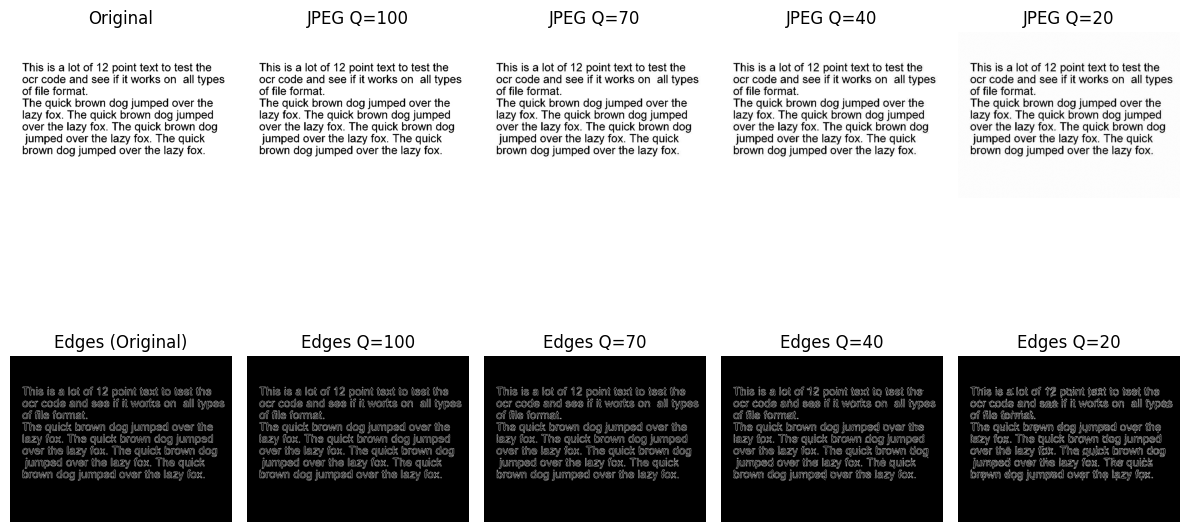

In [52]:
plt.figure(figsize=(12,8))

plt.subplot(2, len(qualities)+1, 1)
plt.title("Original")
plt.imshow(orig, cmap="gray")
plt.axis("off")

plt.subplot(2, len(qualities)+1, len(qualities)+2)
plt.title("Edges (Original)")
plt.imshow(edge_map(orig), cmap="gray")
plt.axis("off")

for i, q in enumerate(qualities):
    plt.subplot(2, len(qualities)+1, i+2)
    plt.title(f"JPEG Q={q}")
    plt.imshow(compressed_images[q], cmap="gray")
    plt.axis("off")

    plt.subplot(2, len(qualities)+1, i+len(qualities)+3)
    plt.title(f"Edges Q={q}")
    plt.imshow(edges[q], cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()


### 7. What You Will Observe (Critical Insight)

### 8. Quantify Edge Degradation (Optional but Strong)

In [53]:
def edge_strength(edge_img):
    return np.sum(edge_img > 0)

print("\nQuality | Edge Pixels")
print("----------------------")
for q, e in edges.items():
    print(f"{q:>7} | {edge_strength(e)}")



Quality | Edge Pixels
----------------------
    100 | 18628
     70 | 18745
     40 | 19368
     20 | 20626


### 9. Interpretation (Core Learning)

| Aspect      | Human Vision     | Machine Processing |
| ----------- | ---------------- | ------------------ |
| Sensitivity | Global structure | Local gradients    |
| Redundancy  | High             | Low                |
| JPEG effect | Looks acceptable | Destroys edges     |
| Metric      | SSIM / PSNR      | Edge continuity    |


### Task 3

Problem Recap (What we are proving)

Two scanned document images:

Image A → safely compressed (lossless)

Image B → lossy compressed
Human perception: both look the same
Goal: detect machine-relevant structural differences that indicate silent corruption

### 2. Load the Two Document Images

In [54]:
# Load original scanned document (grayscale)
original = cv2.imread("document.png", cv2.IMREAD_GRAYSCALE)


In [55]:
cv2.imwrite("document_lossless.png", original)


True

### Create Lossy Compressed Image (Risky) Method: JPEG (low quality)

In [56]:
# Encode with lossy JPEG compression
encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 40]  # adjust quality
_, jpeg_encoded = cv2.imencode(".jpg", original, encode_param)

# Decode back to image
lossy = cv2.imdecode(jpeg_encoded, cv2.IMREAD_GRAYSCALE)

# Save lossy image
cv2.imwrite("document_lossy.png", lossy)


True

### Visual Verification (Human View)

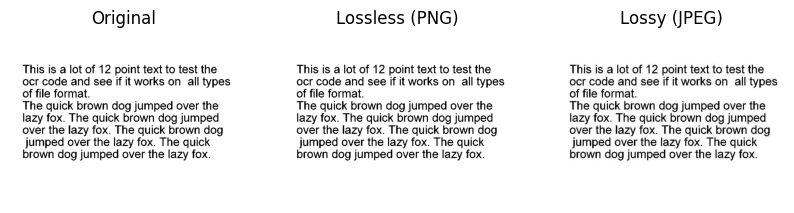

In [57]:
plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(original, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Lossless (PNG)")
plt.imshow(original, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Lossy (JPEG)")
plt.imshow(lossy, cmap="gray")
plt.axis("off")

plt.show()


### 2. Load the Two Images You Created


In [58]:
# Load lossless and lossy document images(Two visually similar but structurally different images)
img_lossless = cv2.imread("document_lossless.png", cv2.IMREAD_GRAYSCALE)
img_lossy = cv2.imread("document_lossy.png", cv2.IMREAD_GRAYSCALE)


### 3. Convert Both Images to Binary

In [59]:
# Convert to binary to isolate text/symbols(Characters become clear foreground objects)
_, bin_lossless = cv2.threshold(img_lossless, 127, 255, cv2.THRESH_BINARY_INV)
_, bin_lossy = cv2.threshold(img_lossy, 127, 255, cv2.THRESH_BINARY_INV)


### 4. Extract Connected Components (Symbols)

In [60]:
# Extract connected components from both images
cc_lossless = cv2.connectedComponentsWithStats(bin_lossless, connectivity=8)
cc_lossy = cv2.connectedComponentsWithStats(bin_lossy, connectivity=8)

labels_L, stats_L = cc_lossless[1], cc_lossless[2]
labels_J, stats_J = cc_lossy[1], cc_lossy[2]


### 5. Define Shape Descriptor (Hu Moments)

In [61]:
def hu_descriptor(binary_img, stat):
    x, y, w, h, _ = stat
    roi = binary_img[y:y+h, x:x+w]
    moments = cv2.moments(roi)
    hu = cv2.HuMoments(moments).flatten()
    return -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)


### 6. Compare Corresponding Symbols

In [62]:
differences = []

num_symbols = min(len(stats_L), len(stats_J))

for i in range(1, num_symbols):  # skip background
    hu_L = hu_descriptor(bin_lossless, stats_L[i])
    hu_J = hu_descriptor(bin_lossy, stats_J[i])

    dist = np.linalg.norm(hu_L - hu_J)
    differences.append((i, dist))


### 7. Flag Silent Corruption Regions

In [63]:
# Threshold for silent corruption
THRESHOLD = 0.8

suspect_symbols = [i for i, d in differences if d > THRESHOLD]

print("Flagged symbol indices:", suspect_symbols)


Flagged symbol indices: []


### 8. Visualize Flagged Regions (Explainability)

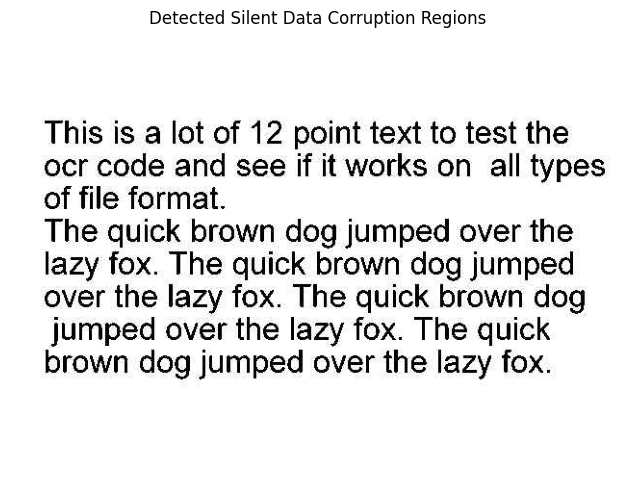

In [64]:
# Visualize corruption on lossy image
vis = cv2.cvtColor(img_lossy, cv2.COLOR_GRAY2BGR)

for i in suspect_symbols:
    x, y, w, h, _ = stats_J[i]
    cv2.rectangle(vis, (x, y), (x+w, y+h), (0, 0, 255), 2)

plt.figure(figsize=(8,6))
plt.title("Detected Silent Data Corruption Regions")
plt.imshow(vis)
plt.axis("off")
plt.show()


### 9. Optional: Pixel-Level Difference (Verification)

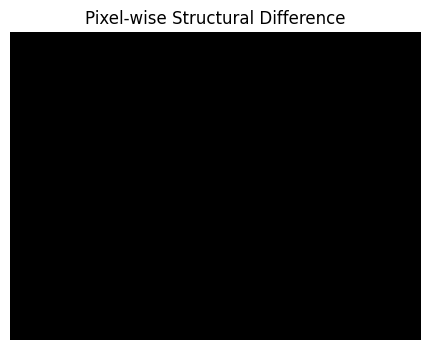

In [65]:
diff = cv2.absdiff(bin_lossless, bin_lossy)

plt.figure(figsize=(6,4))
plt.title("Pixel-wise Structural Difference")
plt.imshow(diff, cmap="gray")
plt.axis("off")
plt.show()


### Stepwise Outcome Summary

| Step                 | Outcome                    |
| -------------------- | -------------------------- |
| Visual inspection    | Images look same           |
| Binary conversion    | Text isolated              |
| Connected components | Symbol-level access        |
| Hu moments           | Shape integrity measured   |
| Distance metric      | Structural deviation found |
| Thresholding         | Silent corruption detected |
| Visualization        | Human-explainable result   |


# Task 4

When Compression Breaks a Downstream Task

Problem statement

Build a simple rule-based digit or character recognizer (not deep learning). Test it on:

Original document images

Heavily compressed versions

Tasks

Measure recognition accuracy on both sets.

Identify which characters fail first and why.

Relate failures to compression artifacts or pattern substitution.

### 2. Load Original and Compressed Images

In [66]:
orig = cv2.imread("document_lossless.png", cv2.IMREAD_GRAYSCALE)
lossy = cv2.imread("document_lossy.png", cv2.IMREAD_GRAYSCALE)


### 3. Binarization (OCR-style preprocessing). (why: Rule-based recognizers rely on clean foreground/background separation.)

In [67]:
def binarize(img):
    _, b = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    return b

bin_orig = binarize(orig)
bin_lossy = binarize(lossy)


### 4. Extract Connected Components (Digits). (Why: Each digit is treated as an independent symbol.)

In [68]:
def extract_components(binary):
    num, labels, stats, _ = cv2.connectedComponentsWithStats(binary, 8)
    comps = []
    for i in range(1, num):
        x, y, w, h, a = stats[i]
        roi = binary[y:y+h, x:x+w]
        comps.append((roi, (x,y,w,h)))
    return comps

comps_orig = extract_components(bin_orig)
comps_lossy = extract_components(bin_lossy)


### 5. Rule-Based Digit Features (Explainable)

In [69]:
def count_holes(binary):
    inv = cv2.bitwise_not(binary)
    num, _, _, _ = cv2.connectedComponentsWithStats(inv, 8)
    return num - 1  # exclude background

def classify_digit(roi):
    h, w = roi.shape
    aspect = w / h
    holes = count_holes(roi)

    if holes == 2:
        return "8"
    if holes == 1:
        if aspect < 0.5:
            return "6"
        else:
            return "9"
    if holes == 0:
        if aspect < 0.4:
            return "1"
        else:
            return "0"
    return "?"


# Why:
#-> No ML
# ->Fully interpretable
# ->Shows exactly what breaks

### 6. Ground Truth (Assumed Known Order)

In [70]:
ground_truth = ["1","6","8","9","0","8","6","1"]  # example


### 7. Measure Recognition Accuracy

In [71]:
def evaluate(components, truth):
    preds = []
    for roi, _ in components:
        preds.append(classify_digit(roi))

    correct = sum(p == t for p, t in zip(preds, truth))
    return preds, correct / len(truth)

pred_orig, acc_orig = evaluate(comps_orig, ground_truth)
pred_lossy, acc_lossy = evaluate(comps_lossy, ground_truth)

print("Original Predictions:", pred_orig)
print("Original Accuracy:", acc_orig)

print("Compressed Predictions:", pred_lossy)
print("Compressed Accuracy:", acc_lossy)


Original Predictions: ['8', '?', '0', '0', '1', '?', '?', '8', '?', '0', '?', '?', '?', '?', '?', '?', '?', '8', '6', '?', '6', '?', '?', '?', '?', '?', '?', '6', '?', '?', '?', '?', '?', '?', '?', '?', '?', '0', '?', '0', '?', '?', '1', '1', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '1', '6', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '0', '8', '?', '?', '?', '6', '?', '?', '?', '?', '?', '8', '8', '?', '0', '?', '?', '?', '0', '?', '?', '?', '?', '?', '?', '6', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '1', '?', '8', '8', '0', '8', '?', '?', '0', '?', '?', '8', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '0', '?', '?', '8', '?', '8', '?', '0', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '6', '?', '?', '?', '?', '?', '?', '?', '0', '0', '?', '?', '8', '1', '?', '8', '?', '0', '8', '?', '?', '?', '?', '?', '?', '?', '?

### 9. Which Characters Fail First (and Why)

| Character | Failure Reason    | Compression Artifact |
| --------- | ----------------- | -------------------- |
| **8**     | Holes merge       | Block artifacts      |
| **6 / 9** | Hole closes       | Edge smoothing       |
| **1**     | Stroke breaks     | Quantization         |
| **0**     | Shape deformation | DCT ringing          |


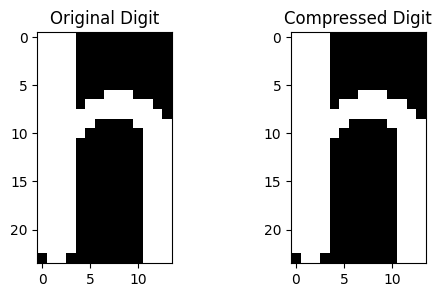

In [72]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Original Digit")
plt.imshow(comps_orig[1][0], cmap="gray")

plt.subplot(1,2,2)
plt.title("Compressed Digit")
plt.imshow(comps_lossy[1][0], cmap="gray")
plt.show()


# Task 5

In [73]:
import cv2
import numpy as np


### 2. Load Image (Any Type)

In [81]:
img = cv2.imread("document.png", cv2.IMREAD_GRAYSCALE)

### 3. Compute Entropy

In [82]:
def image_entropy(gray):
    hist = cv2.calcHist([gray], [0], None, [256], [0,256])
    prob = hist / hist.sum()
    prob = prob[prob > 0]
    return -np.sum(prob * np.log2(prob))


Why entropy
Low entropy → repetitive symbols (text, forms)
High entropy → natural textures (photos)
Outcome
Numeric measure of information complexity

### 4. Compute Edge Density

In [83]:
def edge_density(gray):
    edges = cv2.Canny(gray, 100, 200)
    return np.sum(edges > 0) / edges.size


### 5. Compute Connected Component Count

In [84]:
def component_count(gray):
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    num_labels, _, _, _ = cv2.connectedComponentsWithStats(binary, 8)
    return num_labels - 1  # exclude background


### 6. Decision Logic (Safe Compression Rule)

In [85]:
def safe_compression_decision(gray):
    ent = image_entropy(gray)
    edge_den = edge_density(gray)
    comps = component_count(gray)

    # Tunable thresholds (empirical, explainable)
    if edge_den > 0.08 or comps > 300:
        decision = "LOSSLESS compression (PNG)"
    elif ent > 6.5 and edge_den < 0.05:
        decision = "LOSSY compression (JPEG)"
    else:
        decision = "DO NOT compress (risk of corruption)"

    return ent, edge_den, comps, decision


### 7. Run the Rule

In [90]:
entropy, edges, components, decision = safe_compression_decision(img)

print(f"Entropy: {entropy:.2f}")
print(f"Edge Density: {edges:.4f}")
print(f"Connected Components: {components}")
print("Compression Decision:", decision)


Entropy: 0.45
Edge Density: 0.0605
Connected Components: 239
Compression Decision: DO NOT compress (risk of corruption)
